In [ ]:
!wget https://datahack-prod.s3.amazonaws.com/test_file/test_nfaJ3J5.csv
!wget https://datahack-prod.s3.amazonaws.com/train_file/train_0irEZ2H.csv
!wget https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_pzljTaX.csv

--2020-07-12 17:31:01--  https://datahack-prod.s3.amazonaws.com/test_file/test_nfaJ3J5.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.64.120
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.64.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 684259 (668K) [text/csv]
Saving to: ‘test_nfaJ3J5.csv’

test_nfaJ3J5.csv    100%[===================>] 668.22K  1.17MB/s    in 0.6s    

2020-07-12 17:31:02 (1.17 MB/s) - ‘test_nfaJ3J5.csv’ saved [684259/684259]

--2020-07-12 17:31:08--  https://datahack-prod.s3.amazonaws.com/train_file/train_0irEZ2H.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.64.32
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.64.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7822684 (7.5M) [text/csv]
Saving to: ‘train_0irEZ2H.csv’

train_0irEZ2H.csv   100%[========

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
train = pd.read_csv('train_0irEZ2H.csv')
test = pd.read_csv('test_nfaJ3J5.csv')

In [30]:
train.tail(5)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12
150149,212644,09/07/13,9984,679023,234.4125,234.4125,0,0,15


In [31]:
test.head(5)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0


In [32]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(record_ID          0
 week               0
 store_id           0
 sku_id             0
 total_price        1
 base_price         0
 is_featured_sku    0
 is_display_sku     0
 units_sold         0
 dtype: int64, record_ID          0
 week               0
 store_id           0
 sku_id             0
 total_price        0
 base_price         0
 is_featured_sku    0
 is_display_sku     0
 dtype: int64, (150150, 9), (13860, 8), record_ID            int64
 week                object
 store_id             int64
 sku_id               int64
 total_price        float64
 base_price         float64
 is_featured_sku      int64
 is_display_sku       int64
 units_sold           int64
 dtype: object)

In [33]:
train['total_price']=train['total_price'].fillna(method='bfill')

In [34]:
k=['week']
for i in k:
  train[i] = pd.to_datetime(train[i])
  test[i] = pd.to_datetime(test[i])

In [35]:
for i in k:
  test[i+'_'+'day'] = test[i].dt.day
  test[i+'_'+'weekofyear'] = test[i].dt.weekofyear
  test[i+'_'+'month'] = test[i].dt.month
  test[i+'_'+'dayofweek'] =test[i].dt.dayofweek
  test[i+'_'+'weekend'] = (test[i].dt.weekday >=5).astype(int)
  train[i+'_'+'day'] = train[i].dt.day
  train[i+'_'+'weekofyear'] = train[i].dt.weekofyear
  train[i+'_'+'month'] = train[i].dt.month
  train[i+'_'+'dayofweek'] = train[i].dt.dayofweek
  train[i+'_'+'weekend'] = (train[i].dt.weekday >=5).astype(int)

In [36]:
train.nunique(),test.nunique()

(record_ID          150150
 week                  130
 store_id               76
 sku_id                 28
 total_price           646
 base_price            572
 is_featured_sku         2
 is_display_sku          2
 units_sold            708
 week_day               31
 week_weekofyear        51
 week_month             12
 week_dayofweek          7
 week_weekend            2
 dtype: int64, record_ID          13860
 week                  12
 store_id              76
 sku_id                28
 total_price          442
 base_price           370
 is_featured_sku        2
 is_display_sku         2
 week_day              11
 week_weekofyear       12
 week_month             7
 week_dayofweek         4
 week_weekend           2
 dtype: int64)

In [37]:
del train['week']
del test['week']

In [38]:
train_df=train
test_df=test

In [115]:
X = train_df.drop(labels=['units_sold'], axis=1)
y = train_df['units_sold'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=42)

In [116]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((142642, 12), (142642,), (7508, 12), (7508,))

In [117]:
from math import sqrt 
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [118]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.1, 
         'num_iterations': 3500,
         'num_leaves': 200,
         'max_depth': -1,
         'min_data_in_leaf': 12,
         'bagging_fraction': 0.90,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.80,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 200
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', mean_squared_error(y_cv,y_pred_lgbm))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 20.9769
[200]	valid_0's rmse: 19.7806
[300]	valid_0's rmse: 19.3038
[400]	valid_0's rmse: 19.0925
[500]	valid_0's rmse: 18.9894
[600]	valid_0's rmse: 18.9343
[700]	valid_0's rmse: 18.8865
[800]	valid_0's rmse: 18.841
[900]	valid_0's rmse: 18.8331
[1000]	valid_0's rmse: 18.8075
[1100]	valid_0's rmse: 18.7965
[1200]	valid_0's rmse: 18.7913
[1300]	valid_0's rmse: 18.8255
Early stopping, best iteration is:
[1166]	valid_0's rmse: 18.7862
RMSLE: 352.92214971681545


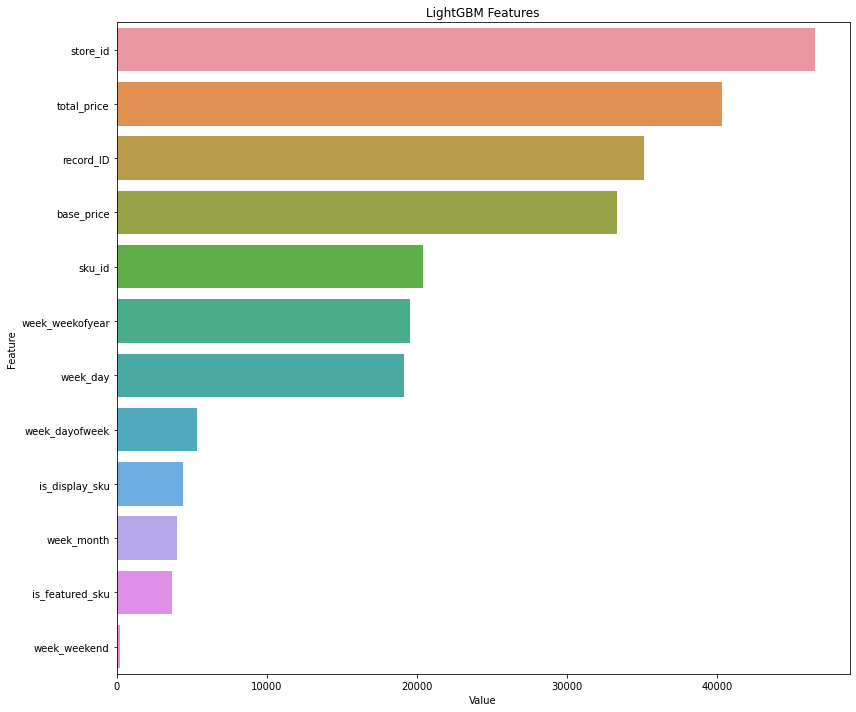

In [119]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [120]:
Xtest = test_df

In [121]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    #lgbm = LGBMRegressor(learning_rate=0.1, n_estimators=1000, random_state=101, subsample=0.8)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", mean_squared_error(y_test, y_pred_lgbm))

    errlgb.append(mean_squared_error(y_test,y_pred_lgbm))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  444.84722715801985


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  448.3037077185177


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  578.9675728997368


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  435.0692435911046


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  470.3137992687869


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  511.5032290880066


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  469.65736108844317


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  429.4391865547865


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  433.6158404958157


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  566.8807760964778


In [122]:
np.mean(errlgb,0)

478.8597943959696

In [123]:
lgbm_final = np.mean(y_pred_totlgb,0)
lgbm_final

array([25.49644925, 22.27416914, 32.11430572, ..., 29.18298336,
        8.94325678, 13.53000097])

In [124]:
submission = pd.DataFrame({
        "record_ID": test['record_ID'],
        "units_sold":abs(lgbm_final)
    })
submission.to_csv('./Av_forcast.csv', index=False)
print(submission)

       record_ID  units_sold
0         212645   25.496449
1         212646   22.274169
2         212647   32.114306
3         212648   33.665338
4         212649   17.048597
...          ...         ...
13855     232281   56.890749
13856     232282   41.629290
13857     232285   29.182983
13858     232286    8.943257
13859     232287   13.530001

[13860 rows x 2 columns]


In [114]:
from google.colab import files
files.download('Av_forcast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>